# **Task 1**

Notion 링크 - https://www.notion.so/Section-2-da2b3439237a451bb02f0f1b304751fc

데이터 링크 - https://www.brightics.ai/community/knowledge-sharing/detail/7043


### **해결해야 하는 문제**

저는 발전소에서 일하는 데이터 분석가입니다.

발전소의 전기 생산은 수요를 예측해서 공급 계획을 수립 후, 전기를 즉시 제공하는 방식으로 진행됩니다.

수요를 정확히 예측하지 못해 과잉공급하거나, 반대로 부족하게 공급하는 경우 배전망이 감당하지 못해, 혹은 전기 사용량을 감당하지 못해 정전이 일어나는 최악의 상황이 벌어질 수 있습니다.

물론 이에 대한 대비책은 분명 존재하나, 모든 대비책엔 비용이 필연적으로 지출되기에, 

우리의 가장 큰 목표는 수요를 **정확히 예측해** 모든 상황이 잘못되지 않도록 대비하는 것입니다.

따라서 건물의 전력 소비 패턴을 분석하려고 합니다.

이를 통해 모델을 학습하고, 평균적인 기후 데이터와 비교해 제대로 분석이 되었는지 확인해봅시다.


### **문제 해결 방법**

여러 기후 데이터와 건물 정보를 기반으로 전력 사용량을 분석합니다.

어떤 유형으로 문제를 해결할 것인가? - **회귀**

해당 데이터셋에서의 Target은? = `elec_amount`

현실의 기후와 전력 사용량, 그리고 건물에 상황에 맞춰 전력 사용량이 변화할 것입니다.

이에 따른 가설을 몇가지 세워볼 수 있는데, 이는 다음과 같습니다.

* 온도에 대한 가설
  * 온도에 따른 소비패턴은 건물과 상관 없이 어느정도 일정할 것이다.
  * 온도가 높아질수록 전력 사용량이 높아질 것이다.

* 건물에 대한 가설
  * 비전기냉방설비를 운영중인 건물의 전력 사용량은 적을 것이다.
  * 태양광시설을 보유중인 건물의 전력 사용량은 적을 것이다.
  * 태양광시설을 보유중인 건물은 일조량에 따라 전력 사용량이 영향을 받을 것이다.

# Task 2

데이터 전처리, EDA, 시각화

* `num` - 건물 번호
* `date_time` - 날짜와 시간 (YYYY-MM-DD HH)
* `elec_amount` - 전력 사용량 (Target)
* `temp` - 기온 
* `windspped` - 풍속
* `humidity` - 습도
* `rainfall` - 강수량
* `sunshine` - 일조량
* `no_elec` - 비전기냉방설비운영
* `sunlight_have` - 태양광보유

In [ ]:
# !pip3 install eli5
# !pip3 install pdpbox
# !pip3 install xgboost==1.7.2

In [ ]:
# import 하는 과정을 앞에서 모두 해서 정리하는게 편할 것 같음.

import pandas as pd
import numpy as np
import eli5

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

mpl.rcParams['figure.figsize'] = (12, 8)

In [ ]:
# 데이터셋 불러오기 

# 구글 드라이브에 업로드 후 변환
file_unique = '1XLhFWgZzv50nCVyfqubCVw68OFBFs5op'
url = 'https://drive.google.com/uc?id=' + file_unique

df_orig = pd.read_csv(url)
df_orig.head()

,num,date_time,elec_amount,temp,windspped,humidity,rainfall,sunshine,no_elec,sunlight_have
0,1.0,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1.0,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1.0,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1.0,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1.0,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [ ]:
# EDA 진행
df = df_orig.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num            122400 non-null  float64
 1   date_time      122400 non-null  object 
 2   elec_amount    122400 non-null  float64
 3   temp           122400 non-null  float64
 4   windspped      122400 non-null  float64
 5   humidity       122400 non-null  float64
 6   rainfall       122400 non-null  float64
 7   sunshine       122400 non-null  float64
 8   no_elec        122400 non-null  float64
 9   sunlight_have  122400 non-null  float64
dtypes: float64(9), object(1)
memory usage: 9.3+ MB


In [ ]:
# 결측치 개수 확인
print('결측치 개수 확인\n', df.isnull().sum(),'\n', sep='')

# 결측치 비율 확인
print('결측치 비율 확인\n', df.isnull().mean(), sep='')

# 결측치는 모든 데이터에서 0인 것을 확인할 수 있었음.

결측치 개수 확인
num              0
date_time        0
elec_amount      0
temp             0
windspped        0
humidity         0
rainfall         0
sunshine         0
no_elec          0
sunlight_have    0
dtype: int64

결측치 비율 확인
num              0.0
date_time        0.0
elec_amount      0.0
temp             0.0
windspped        0.0
humidity         0.0
rainfall         0.0
sunshine         0.0
no_elec          0.0
sunlight_have    0.0
dtype: float64


In [ ]:
# 중복값 개수 확인
print(df.duplicated().sum())

# 중복값 제거
df.drop_duplicates(inplace=True)

0


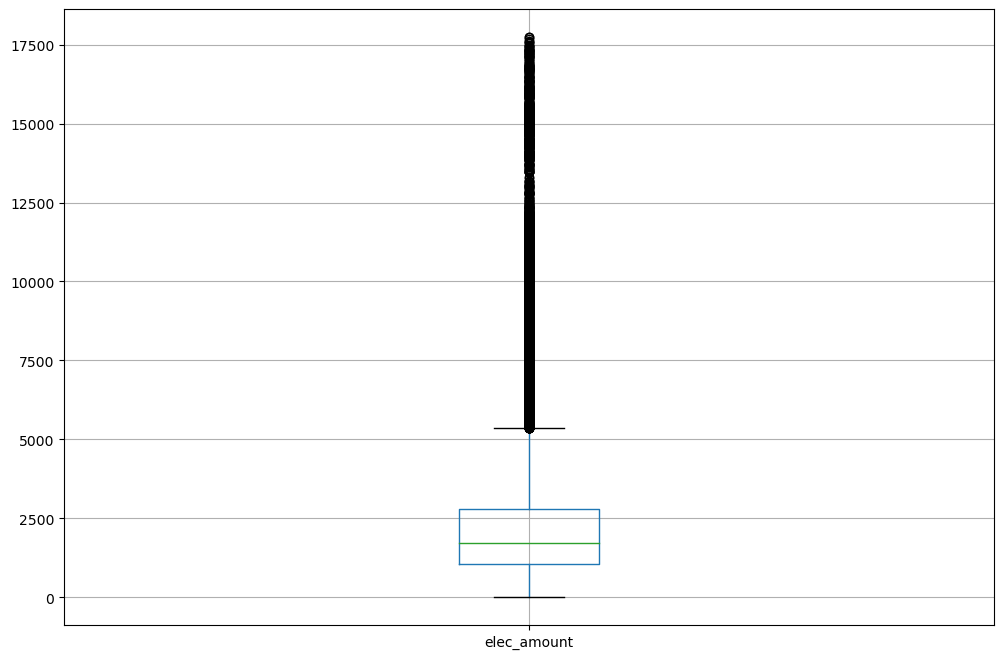

In [ ]:
# 이상치 확인

# Boxplot으로 각 column들을 확인해봤는데 잘 모르겠음.
df[['elec_amount']].boxplot()

# 4분위수를 보고 판단 
# df.describe()

# 여전히 이상치가 있는지 잘 모르겠음. 

In [ ]:
# date_time 이라는 column을 하나하나 다 나누기
df[['year', 'month', 'day', 'hour']] = df['date_time'].str.split('[- ]', expand=True).astype(int)

# 원본 column 제거
df.drop(['date_time'], axis=1, inplace=True)

In [ ]:
# 나눈 결과 확인
df.head()

,num,elec_amount,temp,windspped,humidity,rainfall,sunshine,no_elec,sunlight_have,year,month,day,hour
0,1.0,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020,6,1,0
1,1.0,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020,6,1,1
2,1.0,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,2
3,1.0,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,3
4,1.0,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020,6,1,4


In [ ]:
# 각 column 별 카디널리티 확인
df.nunique()

# year은 2020 하나밖에 없으니 해당 column을 drop
df.drop('year', axis=1, inplace=True)

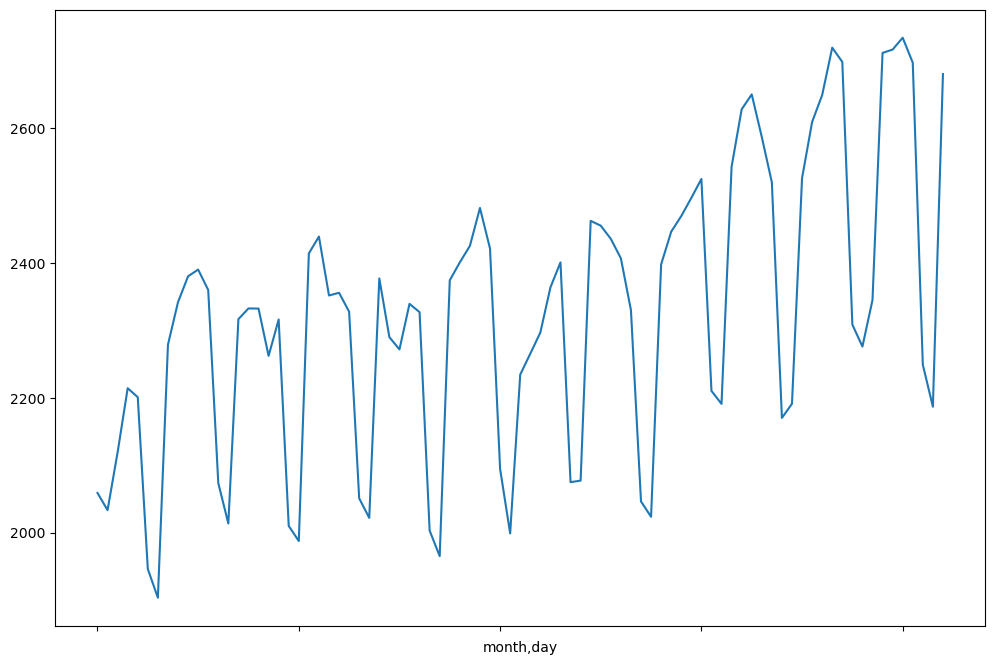

In [ ]:
# 날짜별 전기 사용량 평균
df_grouped = df.groupby(['month', 'day']).mean()

# 그래프 그리기
ax = df_grouped.elec_amount.plot()

# x축 레이블 설정
ax.set_xticklabels('')

plt.show()

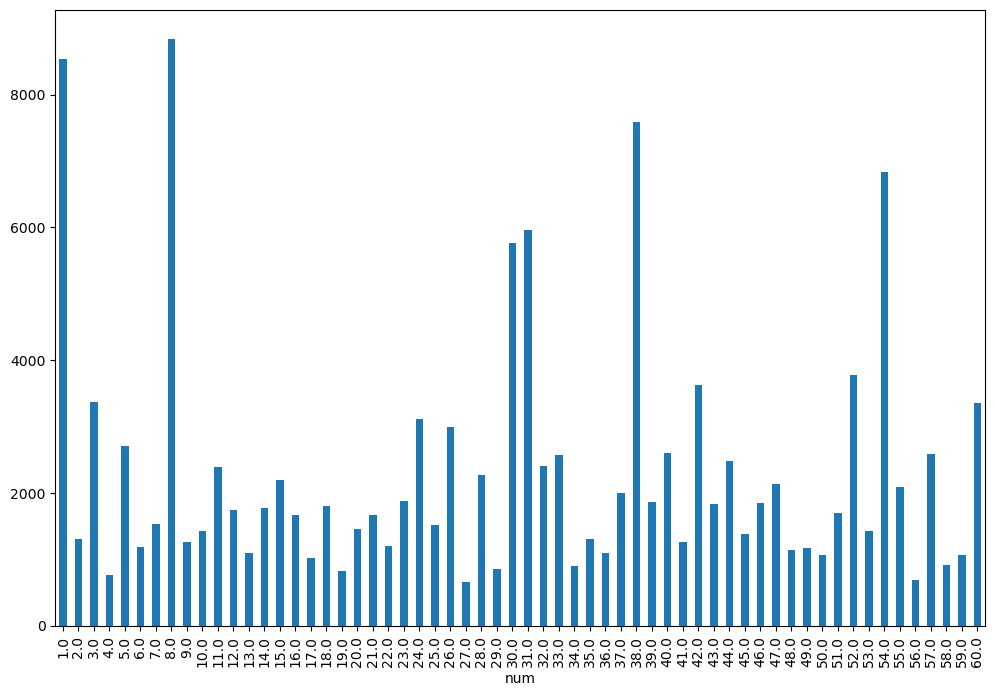

In [ ]:
# 건물별 전기 사용량 평균

df.groupby('num').mean().elec_amount.plot(kind='bar')

# 건물별로 전기 사용량엔 편차가 있는 걸로 보임.

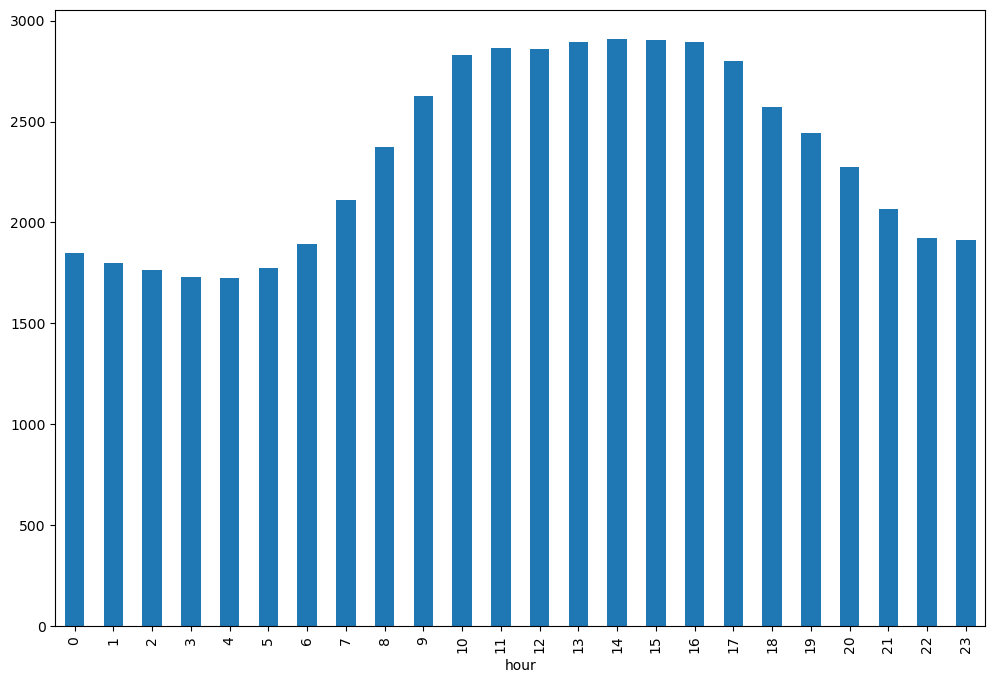

In [ ]:
# hour별 전기 사용량 평균

df.groupby('hour').mean().elec_amount.plot(kind='bar')

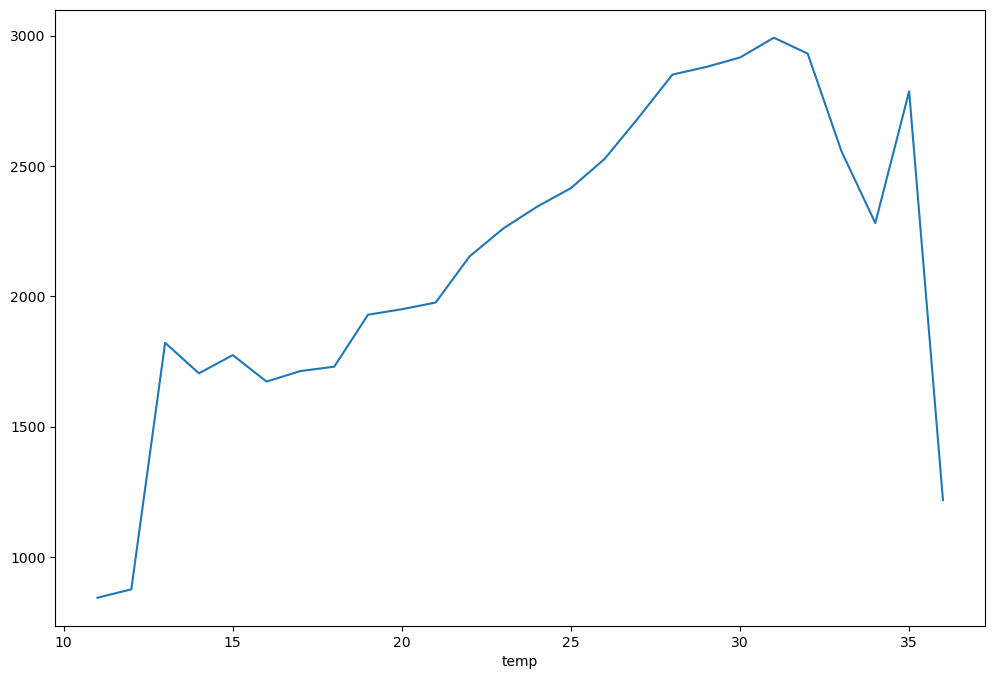

In [ ]:
# 온도별 전기 사용량 평균

# 실수를 그대로 사용하니 막대가 너무 많아져서 수정
grouped = df.groupby(df['temp'].astype(int))['elec_amount'].mean()

# 결과를 그래프로 시각화
grouped.plot()
plt.show()

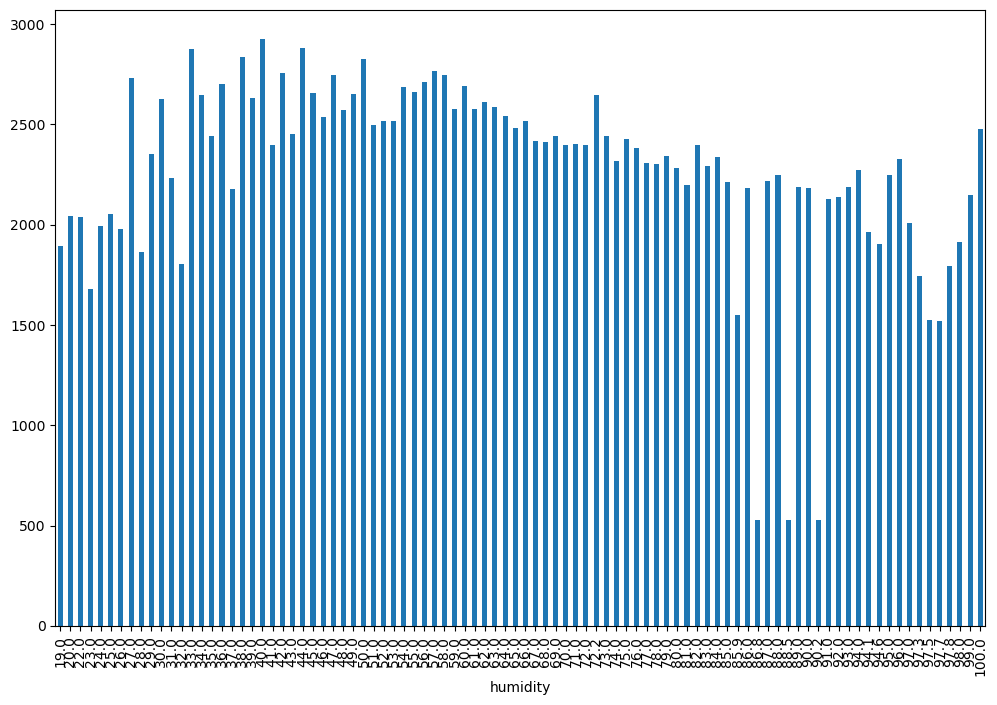

In [ ]:
# 습도별 전기 사용량 평균

df.groupby('humidity').mean().elec_amount.plot(kind='bar')

# 습도별로 상승이나 하강 추세가 보이지 않기에, 의외로 상관이 없는 항목일 수도 있겠다 싶음.

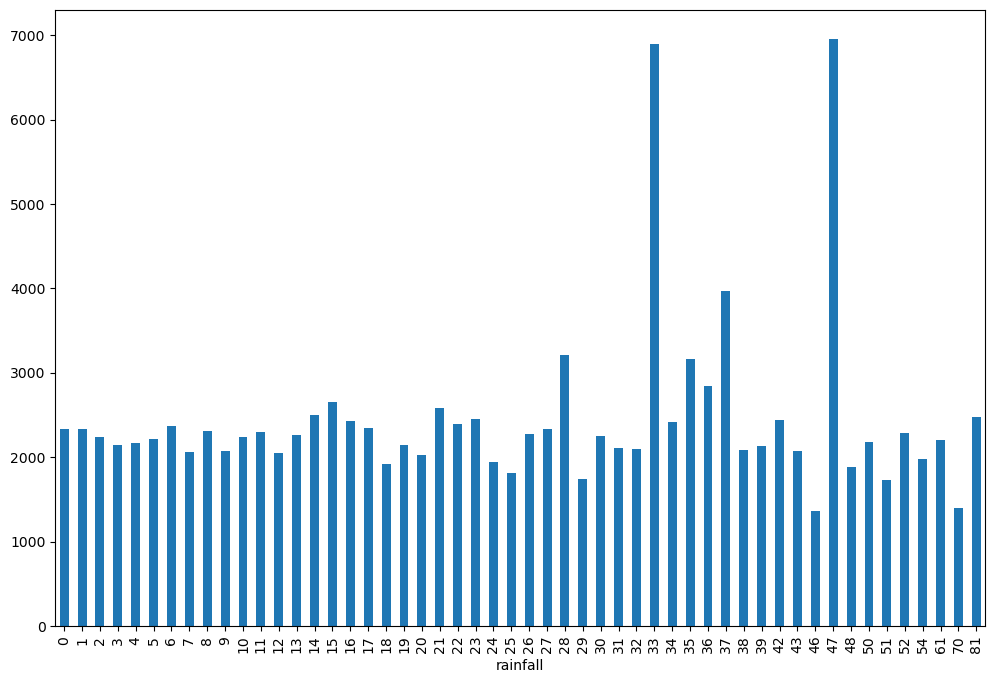

In [ ]:
# 강수량별 전기 사용량 평균

# 실수를 그대로 사용하니 막대가 너무 많아져서 int로 변환
grouped = df.groupby(df['rainfall'].astype(int))['elec_amount'].mean()

# 결과를 그래프로 시각화
grouped.plot(kind='bar')
plt.show()

# 그래프만 보자면 이상하게 높게 올라가는 부분들이 있지만, 결론적으로 이것도 별 상관없는 내용인가 싶음.

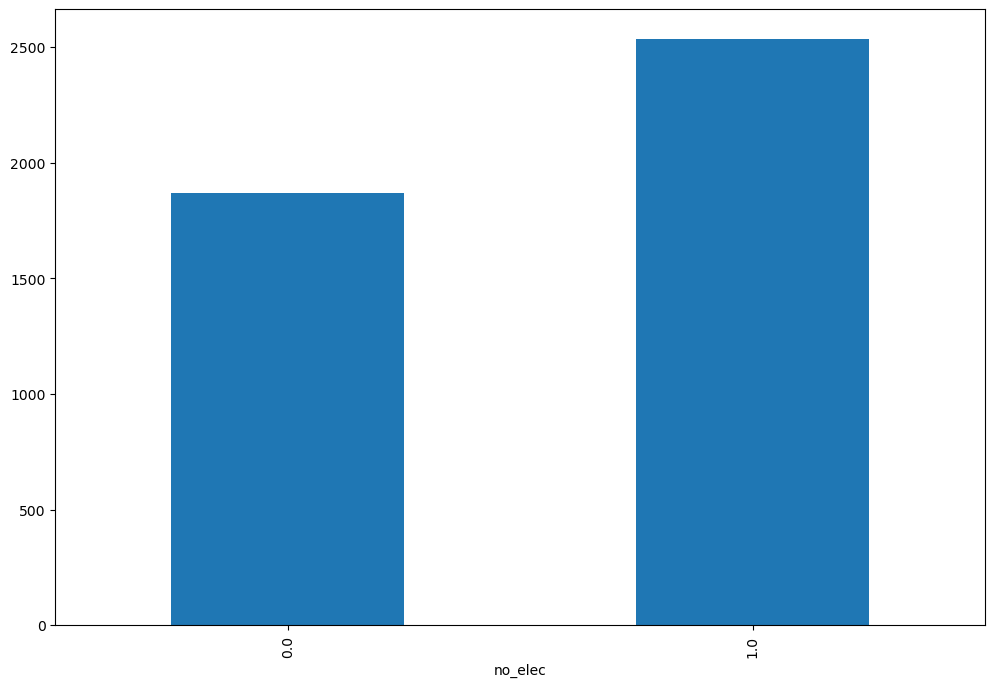

In [ ]:
 # 비전기 냉방시설 보유 유무에 따른 평균

 df.groupby('no_elec').mean().elec_amount.plot(kind='bar')

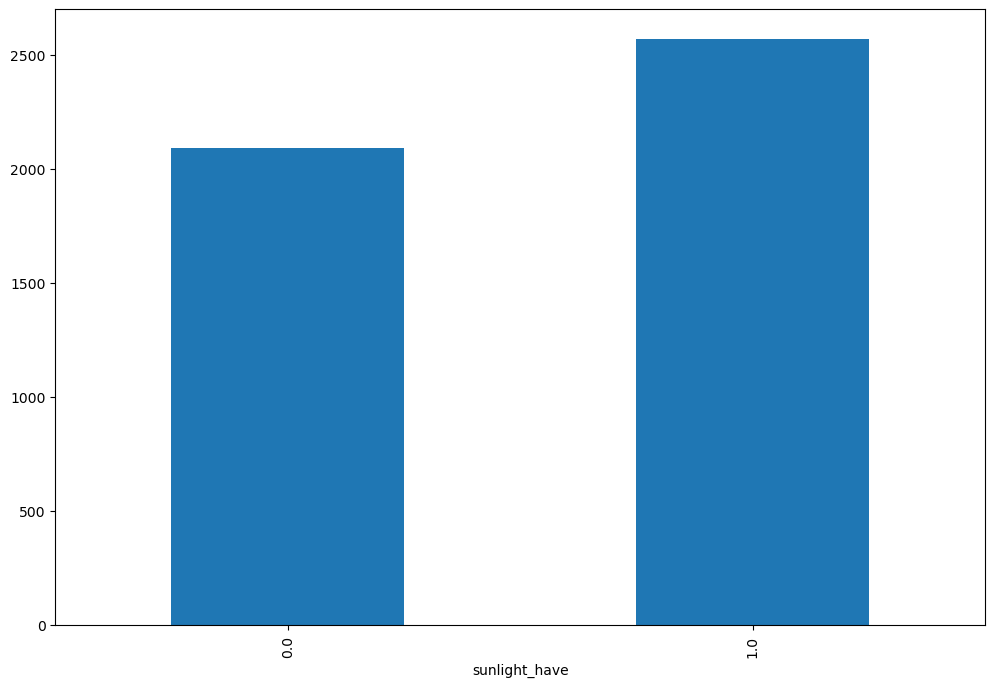

In [ ]:
# 태양광 보유 유무에 따른 평균

df.groupby('sunlight_have').mean().elec_amount.plot(kind='bar')

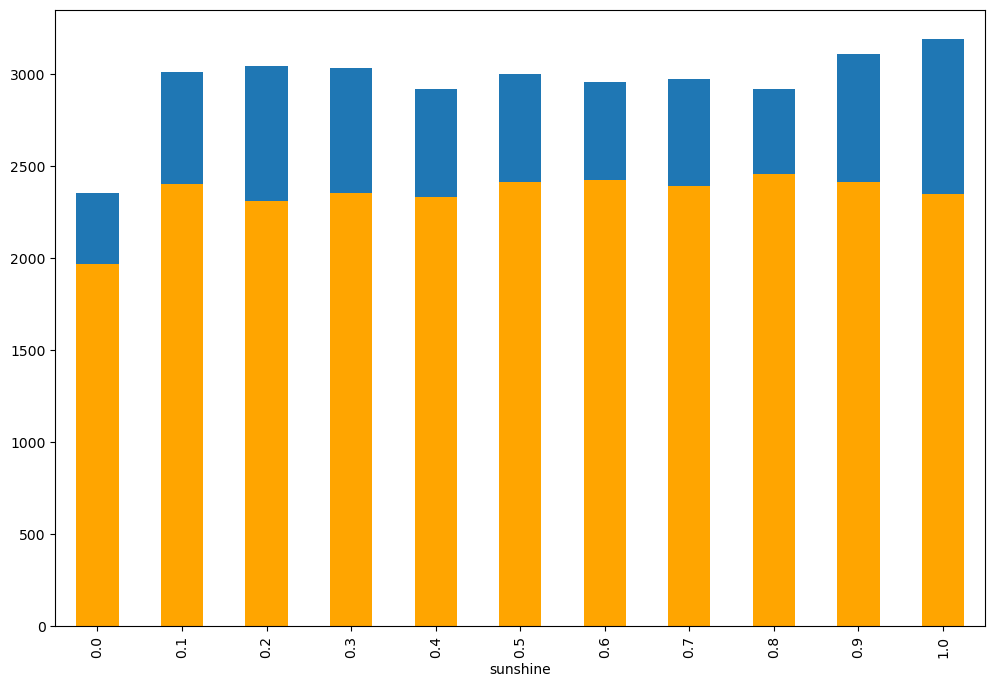

In [ ]:
# 태양광 보유 유무, 그리고 일조량에 따른 변화량

df.query("sunlight_have == 1").groupby('sunshine').mean().elec_amount.plot(kind='bar')
df.query("sunlight_have == 0").groupby('sunshine').mean().elec_amount.plot(kind='bar', color='orange')

plt.show()

### **EDA 결론과 추가 전처리**

**제시했던 가설들**

* 온도에 대한 가설
  * 온도에 따른 소비패턴은 건물과 상관 없이 어느정도 일정할 것이다.
  * 온도가 높아질수록 전력 사용량이 높아질 것이다.

* 건물에 대한 가설
  * 비전기냉방설비를 운영중인 건물의 전력 사용량은 적을 것이다.
  * 태양광시설을 보유중인 건물의 전력 사용량은 적을 것이다.
  * 태양광시설을 보유중인 건물은 일조량에 따라 전력 사용량이 영향을 받을 것이다.

**가설에 대한 분석**

* **온도에 따른 소비패턴은 건물과 상관 없이 어느정도 일정할 것이다.**

  당장 그래프로 모든 건물의 소비패턴을 확인하기는 어려우나, 온도에 따른 사용량 변화는 있는 걸로 보임.

* **온도가 높아질수록 전력 사용량이 높아질 것이다.**

  위의 답변 내용과 동일. 온도가 높아질 수록 전력 사용량이 높아지는 걸로 보임.

* **비전기냉방설비를 운영중인 건물의 전력 사용량은 적을 것이다.**

  사실이 아님. 오히려 높은걸 볼 수 있었음. 전력 사용량이 많다보니 이를 줄이기 위해 설치했을 것으로 예상됨.

* **태양광시설을 보유중인 건물의 전력 사용량은 적을 것이다.**
  
  위와 동일. 사실이 아님. 오히려 높은걸 볼 수 있었음. 전력 사용량이 많다보니 이를 줄이기 위해 설치했을 것으로 예상됨.

* **태양광시설을 보유중인 건물은 일조량에 따라 전력 사용량이 영향을 받을 것이다.**

  사실이 아님. 그래프로 확인해보아도 뚜렷한 변화의 차이를 느끼지 못했음.


**분석 결과를 보고 추가로 해야할 전처리**

알아야 할 정보는 **수요** 이기에, 건물에 따른 편차를 줄이고자 `date_time`이 같은 데이터끼리 합한 다음 분석해보려 함.

그리고 위의 내용 중 태양광 시설 보유 여부나, 비전기냉방설비 운영 여부는 분석에 있어 크게 도움이 되지 않을 것으로 예측되기에, date_time으로 합치는 과정에선 두 데이터를 배제하기로 함.

각 column들을 평균을 내서 데이터를 합쳐보려고 함.

In [ ]:
# 데이터 다시 불러오기
df = df_orig.copy()

# 건물 번호, 태양광 시설 보유 여부, 비전기냉방설비 운영 여부 삭제
df.drop(['num', 'sunlight_have', 'no_elec'], axis=1, inplace=True)
df = df.groupby('date_time').agg({'elec_amount': 'mean', 'temp': 'mean', 'windspped': 'mean', 'humidity': 'mean', 'rainfall': 'mean', 'sunshine': 'mean'}).reset_index()

In [ ]:
df.head()

,date_time,elec_amount,temp,windspped,humidity,rainfall,sunshine
0,2020-06-01 00,1665.076950,18.313333,1.983333,89.633333,0.391667,0.0
1,2020-06-01 01,1630.213888,18.125000,2.275000,91.166667,0.110000,0.0
2,2020-06-01 02,1594.097142,17.903333,2.638333,91.683333,0.036667,0.0
3,2020-06-01 03,1544.555640,17.680000,2.485000,92.466667,0.078333,0.0
4,2020-06-01 04,1536.407105,17.638333,2.861667,92.850000,0.011667,0.0


In [ ]:
# date_time 이라는 column을 하나하나 다 나누기
df[['year', 'month', 'day', 'hour']] = df['date_time'].str.split('[- ]', expand=True).astype(int)

# 원본 column 제거, year도 카디널리티가 1이라 제거
df.drop(['date_time', 'year'], axis=1, inplace=True)

In [ ]:
df.head()

,elec_amount,temp,windspped,humidity,rainfall,sunshine,month,day,hour
0,1665.076950,18.313333,1.983333,89.633333,0.391667,0.0,6,1,0
1,1630.213888,18.125000,2.275000,91.166667,0.110000,0.0,6,1,1
2,1594.097142,17.903333,2.638333,91.683333,0.036667,0.0,6,1,2
3,1544.555640,17.680000,2.485000,92.466667,0.078333,0.0,6,1,3
4,1536.407105,17.638333,2.861667,92.850000,0.011667,0.0,6,1,4


# Task 3

모델링 및 모델 해석


분석 방법? = 회귀분석

Baseline? = Target의 평균

평가지표? = R2 Score, RMSE

In [ ]:
target = 'elec_amount'
features = df.drop(target, axis=1).columns

# 미래의 데이터인 8월을 테스트 셋으로 사용.
df_train = df.query("month != 8")
df_test = df.query("month == 8")

# 특성과 타겟을 분리
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1098, 8)
(366, 8)
(576, 8)


In [ ]:
# 베이스 모델 생성

baseline = y_train.mean()
y_pred_base = [baseline] * len(y_train)

In [ ]:
# 모델 구축

# Encoding 할 feature가 없어보임. 따라서 그냥 진행.
model = XGBRegressor(
    eval_metric="rmse",
    n_estimators=987654321,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.5,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_child_weight=5,
    gamma=0.2,
    tree_method='exact',
    random_state=42,
)

watchlist = [(X_train, y_train), (X_val, y_val)]

model.fit(
    X_train,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=10,
    verbose=0,
)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0.2, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=987654321, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [ ]:
# 튜닝하기 전 지표를 저장

# Base R2 : 0.0
# Base RMSE : 244923.89677683203

# Train R2 : 0.9999084388076895
# Train RMSE : 22.425524014202036

# Validate R2 : 0.8356970300855432
# Validate RMSE : 39674.3911386145

# 튜닝을 반복하며 지표를 확인

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

print(f'Base R2 : {r2_score(y_train, y_pred_base)}')
print(f'Base RMSE : {mean_squared_error(y_train, y_pred_base)}\n')

print(f'Train R2 : {r2_score(y_train, y_pred_train)}')
print(f'Train RMSE : {mean_squared_error(y_train, y_pred_train)}\n')

print(f'Validate R2 : {r2_score(y_val, y_pred_val)}')
print(f'Validate RMSE : {mean_squared_error(y_val, y_pred_val)}')

# 더 나아질 기미가 안보여서 모델 튜닝 스탑

Base R2 : 0.0
Base RMSE : 244923.89677683203

Train R2 : 0.9985437819958627
Train RMSE : 356.6625881298837

Validate R2 : 0.9424236439947893
Validate RMSE : 13903.016297734328


In [ ]:
# Test 데이터 셋에 대한 최종 성능 확인

y_pred_test = model.predict(X_test)

print(f'Test R2 : {r2_score(y_test, y_pred_test)}')
print(f'Test RMSE : {mean_squared_error(y_test, y_pred_test)}')

Test R2 : 0.6700012835598697
Test RMSE : 103117.29628294556


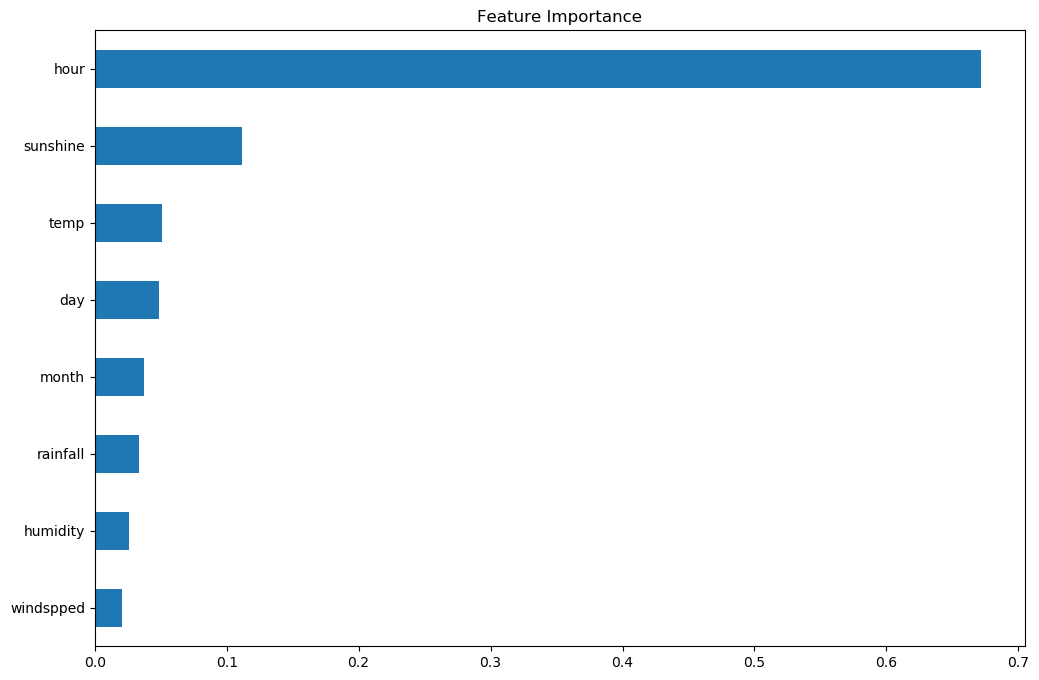

Text(0.5, 1.0, 'Cardinality')

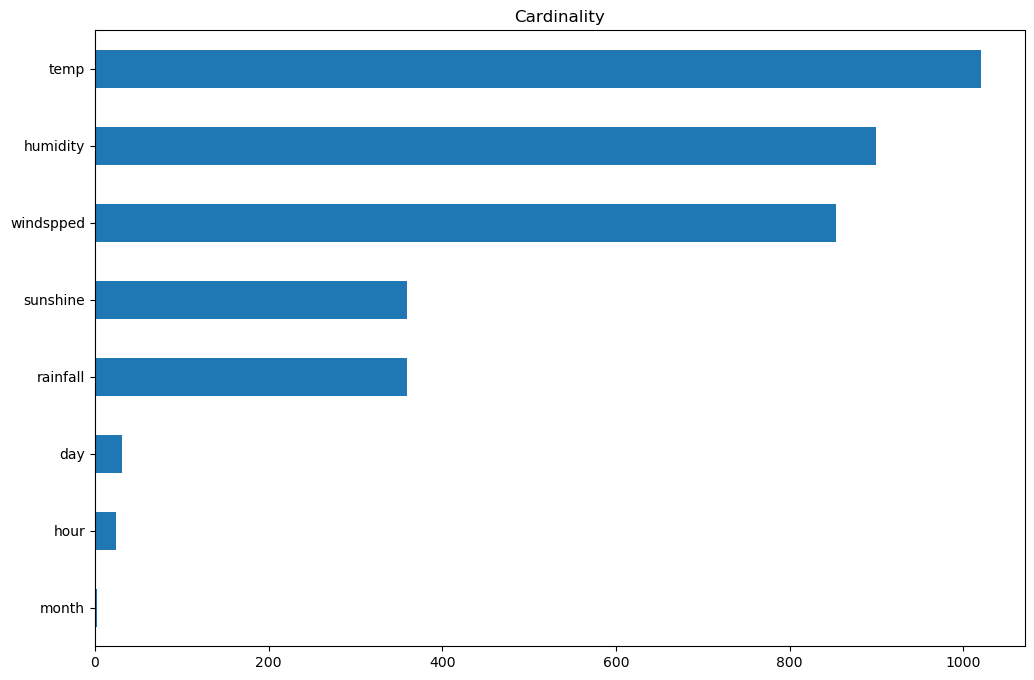

In [ ]:
# 모델 해석

# Feature Importance
importances = pd.Series(model.feature_importances_, X_train.columns)

importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()

X_train.nunique().sort_values().plot.barh()
plt.title("Cardinality")

In [ ]:
# 순열 중요도

permuter = PermutationImportance(
    model,
    scoring="r2", 
    n_iter=10, 
    random_state=42,
)

permuter.fit(X_val, y_val)

PermutationImportance(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             callbacks=None,
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=0.5,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric='rmse',
                                             feature_types=None, gamma=0.2,
                                             gpu_id=-1, grow_policy='depthwise',
                                             importance_type=None,
                                             interaction_constraints='',
                                             learning_rate=0.1, max_bin=256,
                                             max_cat_threshold=64,
                                             max_cat_to_onehot=4,
                                             max_delta_step=0, max_depth=6,
                                             max_leaves=0, min_child_weight=5,
                                             missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=987654321, n_jobs=0,
                                             num_parallel_tree=1,
                                             predictor='auto', random_state=42, ...),
                      n_iter=10, random_state=42, scoring='r2')

Text(0.5, 1.0, 'Permutation Importance')

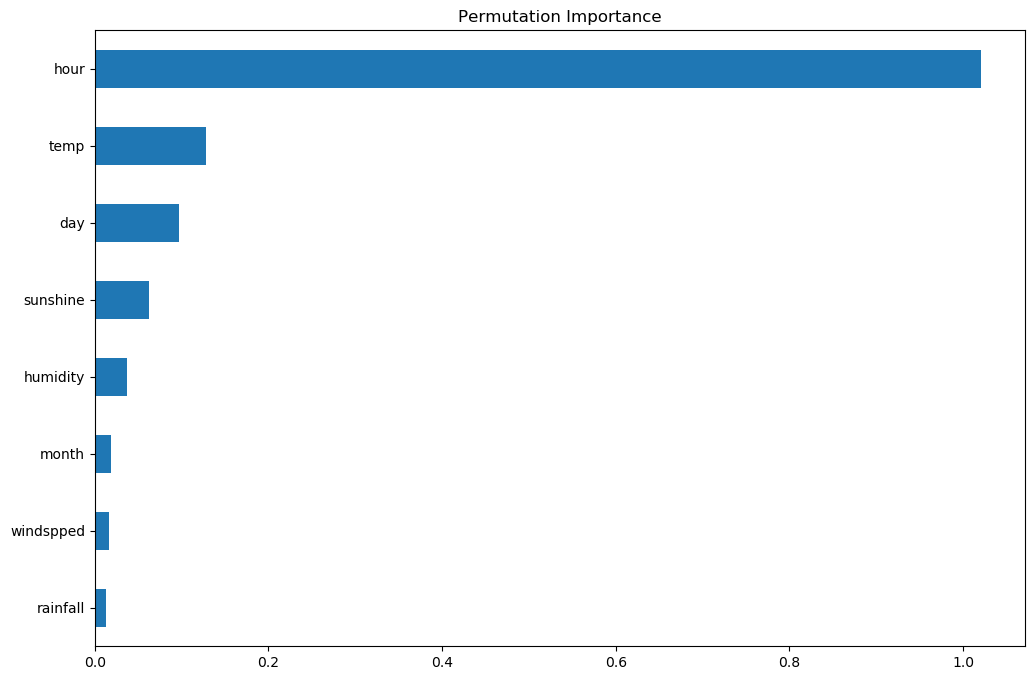

In [ ]:
feature_names = X_val.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance")

In [ ]:
eli5.show_weights(
    permuter,
    top=None, 
    feature_names=feature_names,  
)

Weight,Feature
1.0201 ± 0.0509,hour
0.1278 ± 0.0283,temp
0.0967 ± 0.0125,day
0.0621 ± 0.0133,sunshine
0.0367 ± 0.0092,humidity
0.0187 ± 0.0054,month
0.0160 ± 0.0028,windspped
0.0128 ± 0.0056,rainfall


(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d72058b0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d71da490>})

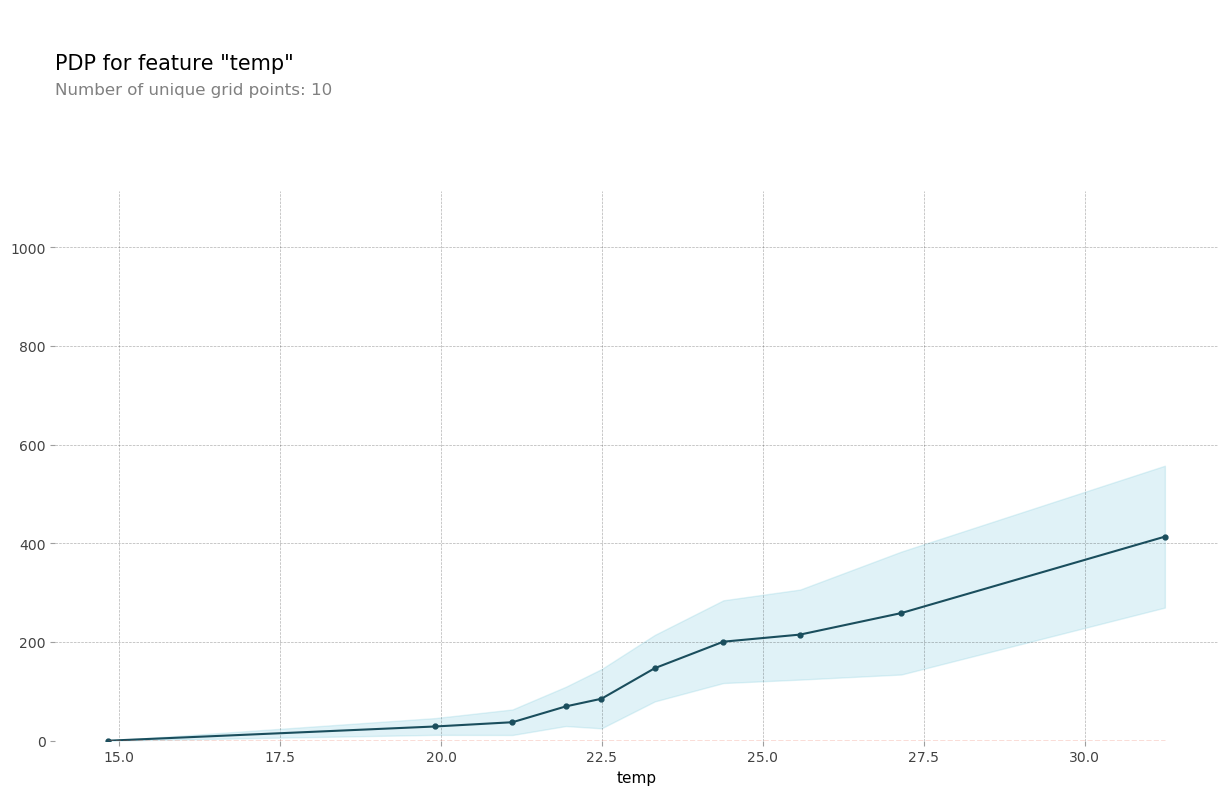

In [ ]:
target_feature = "temp"

isolated = pdp_isolate(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 1500x950 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d6892eb0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d68409a0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d67f81c0>}})

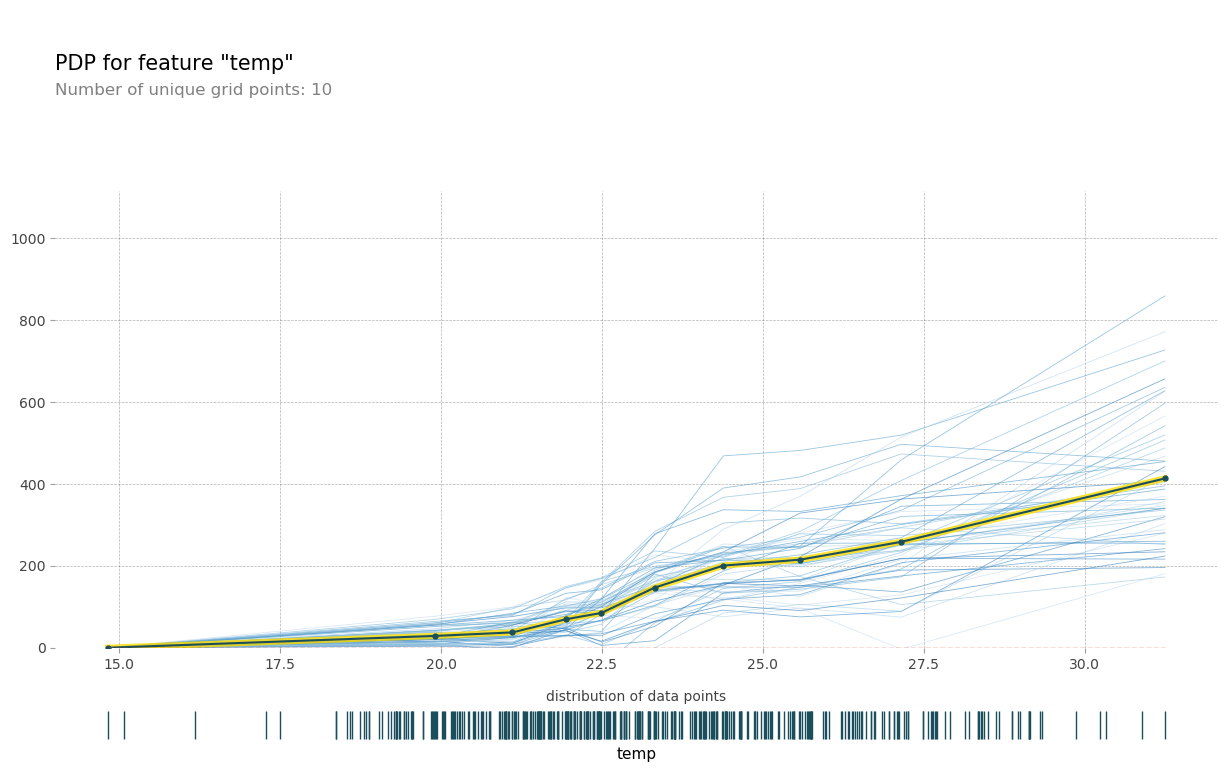

In [ ]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  # ICE plots
    frac_to_plot=50,  # float type을 입력하면 전체 데이터 갯수 중 plotting할 데이터 수의 비율이 됩니다. int type을 입력하면 데이터의 수가 됩니다.
    plot_pts_dist=True,
)

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d6689160>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d6821af0>})

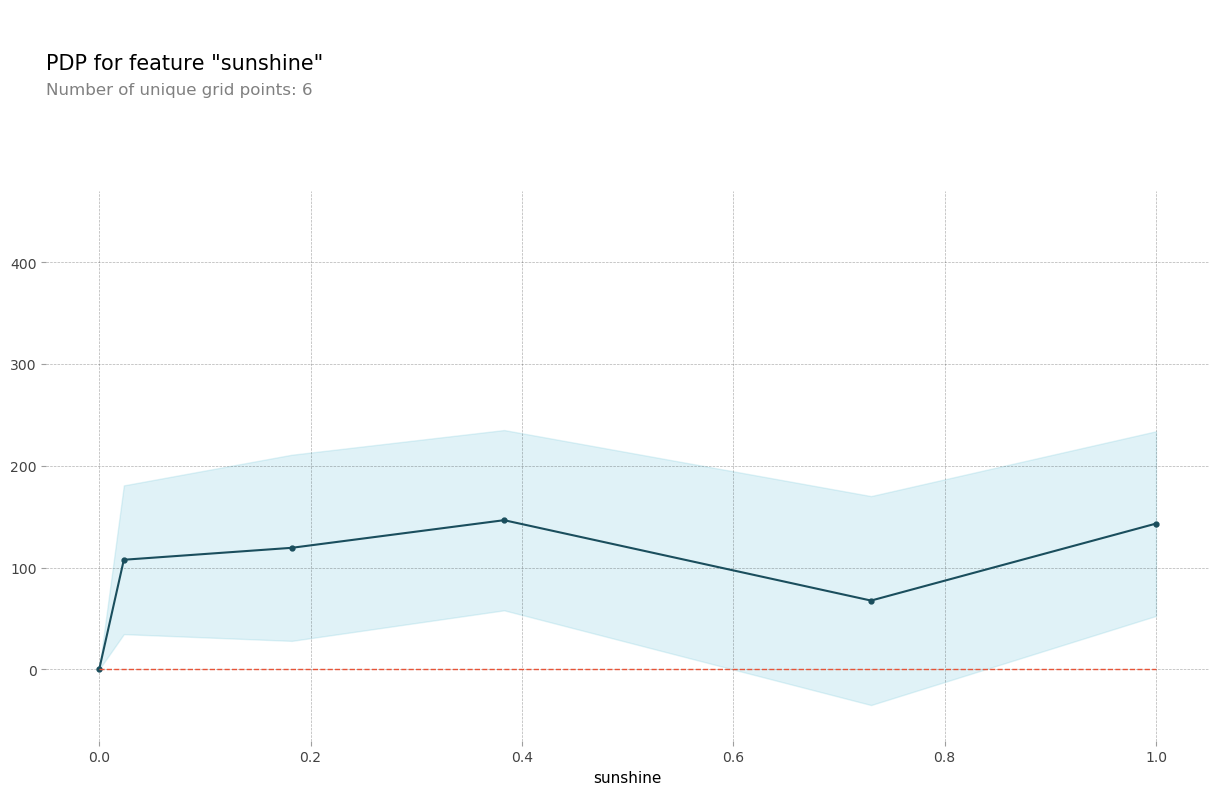

In [ ]:
target_feature = "sunshine"

isolated = pdp_isolate(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 1500x950 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d65ae4f0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d65cb9a0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d65821c0>}})

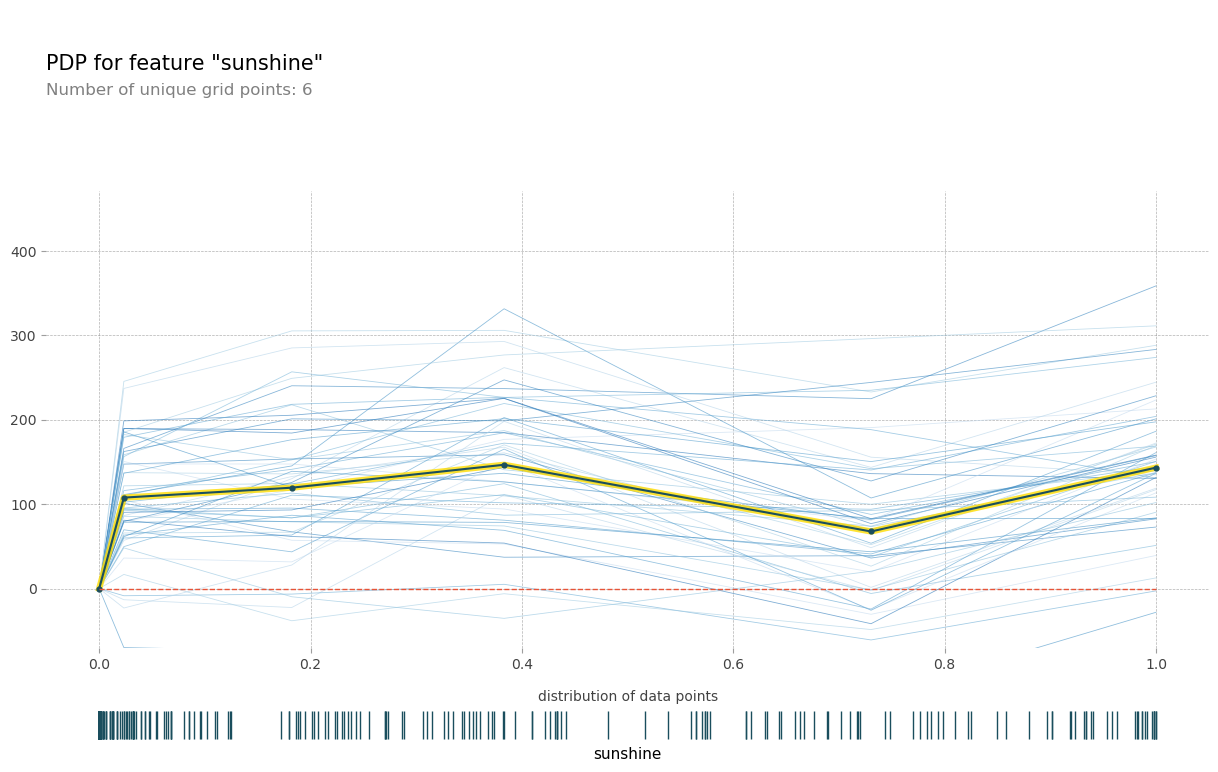

In [ ]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  # ICE plots
    frac_to_plot=50,  # float type을 입력하면 전체 데이터 갯수 중 plotting할 데이터 수의 비율이 됩니다. int type을 입력하면 데이터의 수가 됩니다.
    plot_pts_dist=True,
)

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d64dae20>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d6476e20>})

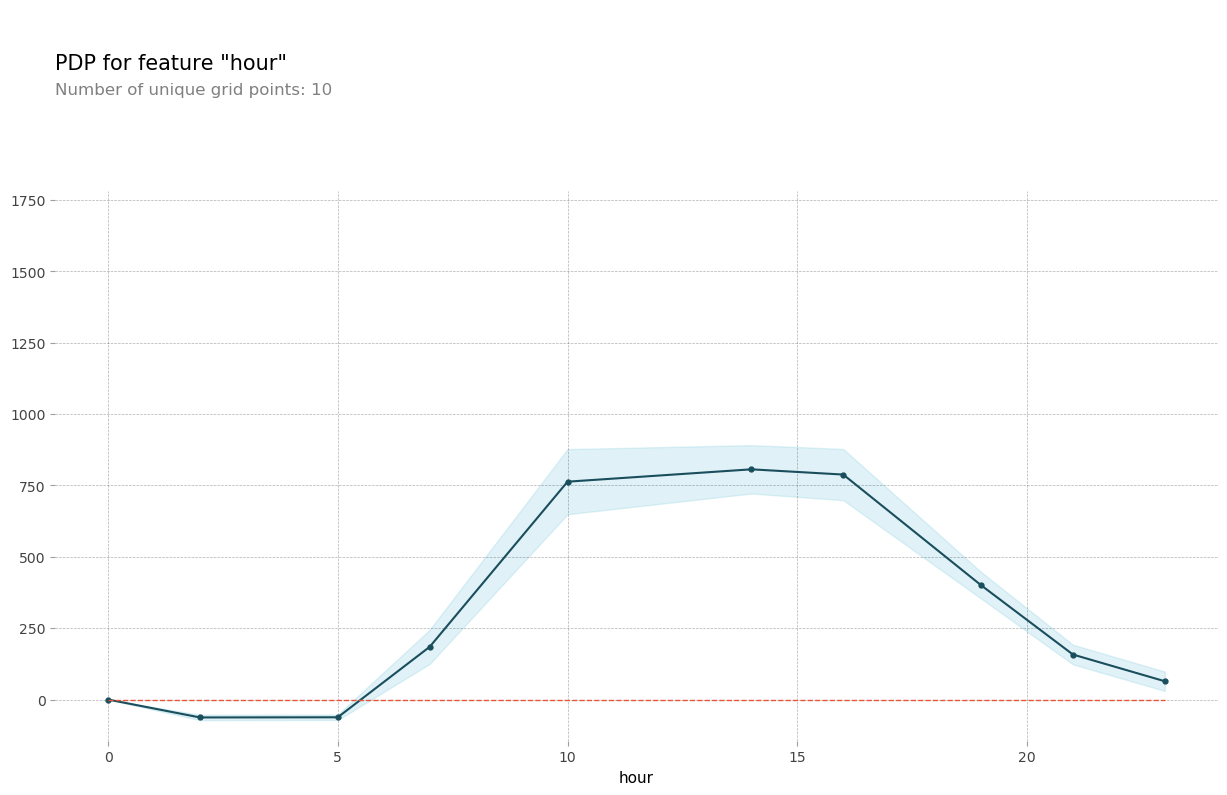

In [ ]:
target_feature = "hour"

isolated = pdp_isolate(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 1500x950 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d65b2a30>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d63baca0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d63304f0>}})

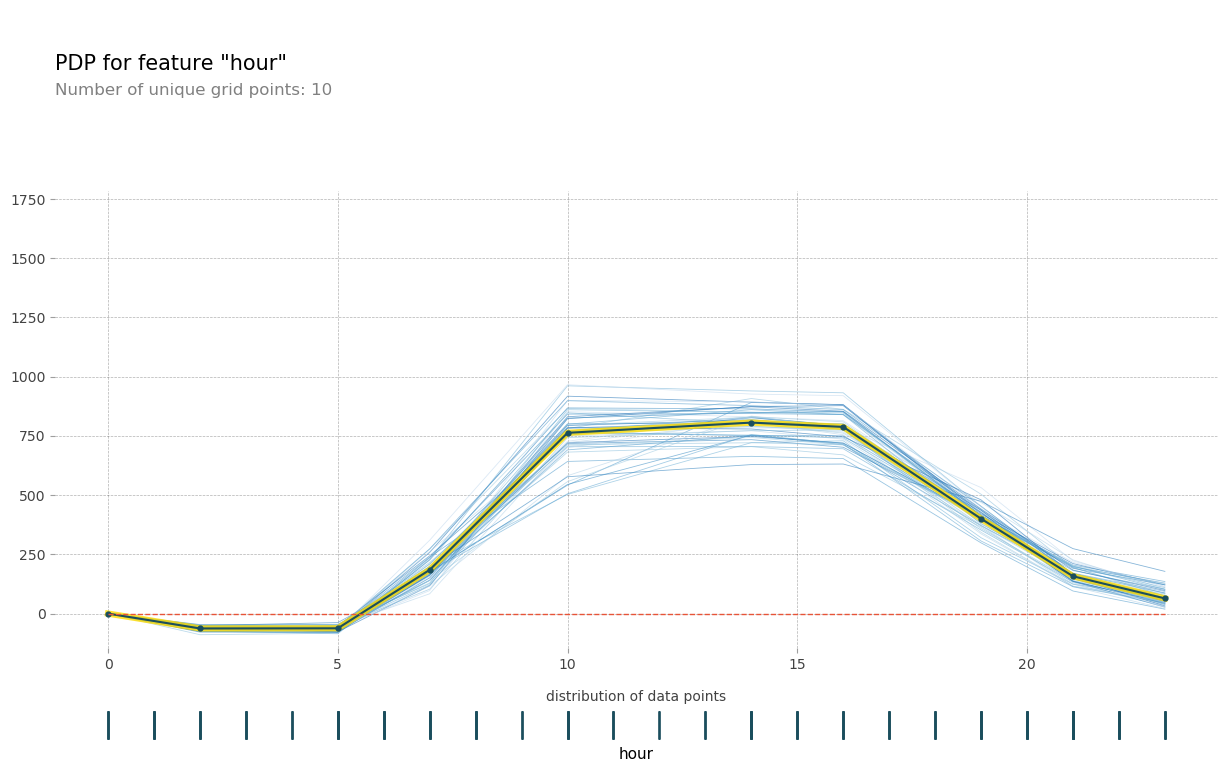

In [ ]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  # ICE plots
    frac_to_plot=50,  # float type을 입력하면 전체 데이터 갯수 중 plotting할 데이터 수의 비율이 됩니다. int type을 입력하면 데이터의 수가 됩니다.
    plot_pts_dist=True,
)

In [ ]:
target_features = ["hour", "temp"]

interaction = pdp_interact(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    features=target_features,
)

(<Figure size 750x950 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d61b8130>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f54d6252430>})

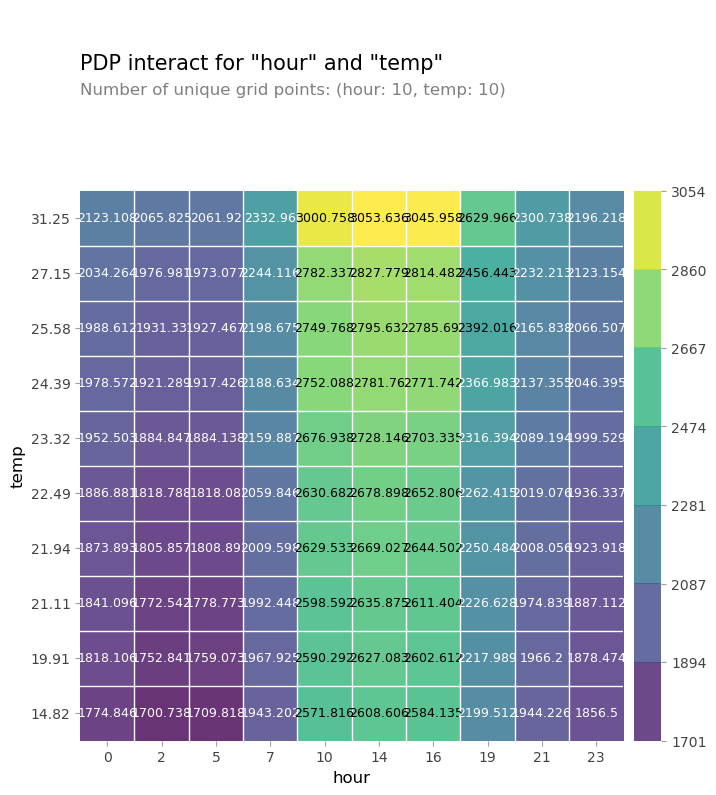

In [ ]:
pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)